### Key Features:
- Data Loading:
Uses Pandas to read two Excel files containing batch data and metabolite data.
df holds viable cell counts, while metabolite stores metabolite information.
- Model Fitting:
Defines a function fitted_vcd to model viable cell growth over time.
Uses curve_fit to estimate the model parameters for each batch, and visualizes the actual and predicted data.
- Growth Rate Calculation:
Calculates growth rates for each batch using a defined time interval (delta_time).
Updates the batch DataFrame with a new column 'Growth Rate'.
- Specific Rate Calculation:
Implements the calculate_specific_rate function to compute specific rates of metabolites uptake/secretion.
Loops through each batch and specified time intervals, calculating specific rates for different metabolites.
- Results Storage:
Stores calculated specific rates in a structured format using dictionaries (results and cumulative_results).
Supports further analysis and export.
### Requirements:
Data Files: Excel files with specific sheets and header structures, which must align with the code.
### Usage:
- Adjust File Paths:
Update file paths (file_path and file_path_meta) and file names to point to your actual data files.
- Check Data Structure:
Ensure data files contain the necessary columns and rows, and are grouped by the appropriate batch IDs.
- Run the Code:
Execute the script to load data, fit models, calculate growth rates, and compute specific rates.
- Review Results:
Check the visualizations, results lists, and cumulative results for analysis.
- Extend the Analysis:
Use the results for further analysis, data export, or integration with other tools.

In [2]:
import pickle
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# Read the excel file (model)
#file_path = r"C:\Users\user\Documents\DC\Manual curation_iCHO\Whole-Cell-Network-Reconstruction-for-CHO-cells_origin\Whole-Cell-Network-Reconstruction-for-CHO-cells\Data\ZeLa Data"
file_name = "ELN_Excel data sheet_Bio141 to Bio148.xlsx"
sheet_name = "All data"


#full_path = f"{file_path}/{file_name}"

df_tmp = pd.read_excel(file_name, sheet_name=sheet_name, header = 17)

df = df_tmp[['Batch ID', 'Sample ID', 'Viable Cells', 'Age (h)']]

start_row = 1
end_row = 129


viable_cells = df.iloc[start_row:end_row]  

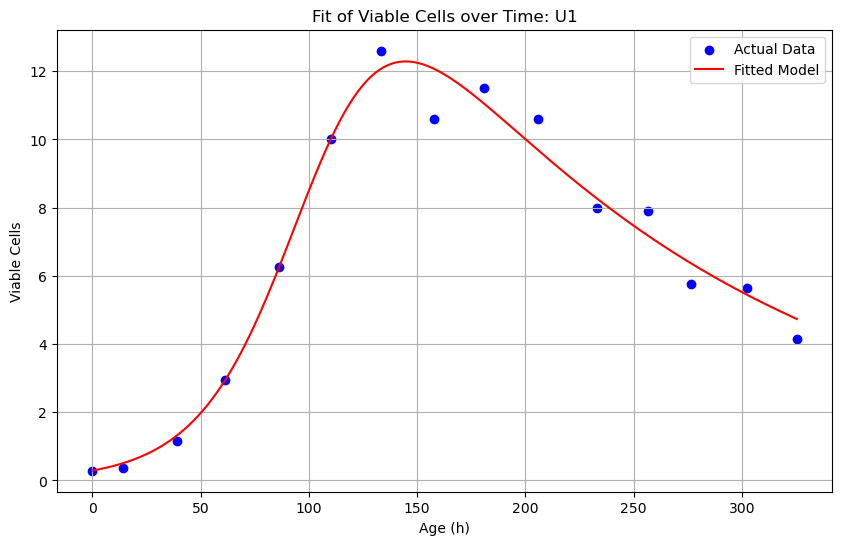

at 0==> initial_vcd:0.18055731550069065; final_vcd:0.29004808364385326; delta_time:12
0.038776566079278776 growth rate
0.039499870844682095 growth rate_log
at 14.033333333333337==> initial_vcd:0.3142355640116748; final_vcd:0.5031660378709382; delta_time:12
0.03852257230393742 growth rate
0.039231441858027495 growth rate_log
at 39.25==> initial_vcd:0.8401966596182118; final_vcd:1.32624991091146; delta_time:12
0.03739251007502835 growth rate
0.03803955331049502 growth rate_log
at 61.13333333333334==> initial_vcd:1.9112899686895222; final_vcd:2.919428326692411; delta_time:12
0.0347822103035432 growth rate
0.035300785684268615 growth rate_log
at 86.16666666666667==> initial_vcd:4.452038496507366; final_vcd:6.239115007011024; delta_time:12
0.02785911594908106 growth rate
0.02812302217778706 growth rate_log
at 110.25000000000003==> initial_vcd:8.213263388584595; final_vcd:10.022793095156828; delta_time:12
0.016538020963994614 growth rate
0.016592622905296544 growth rate_log
at 133.1666666666

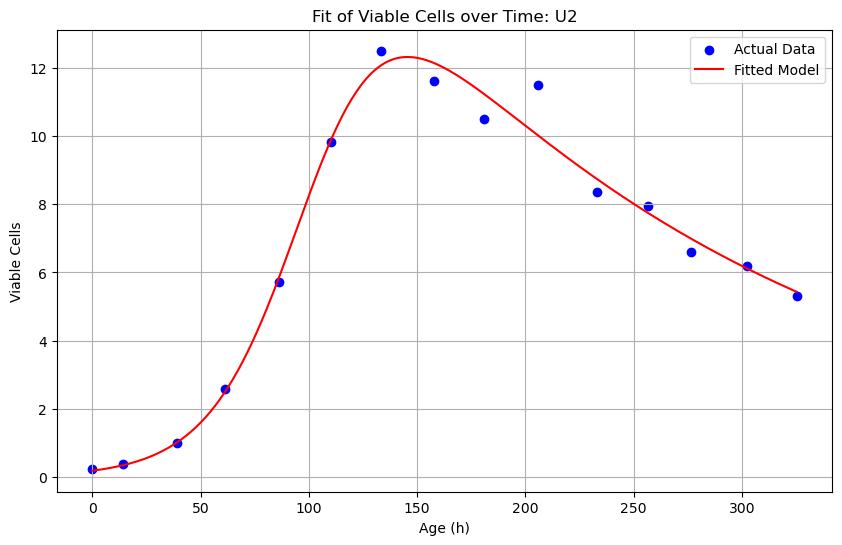

at 0==> initial_vcd:0.11043996797532919; final_vcd:0.18716785687331894; delta_time:12
0.04296923808875579 growth rate
0.04396114562296394 growth rate_log
at 14.033333333333331==> initial_vcd:0.2046299436155201; final_vcd:0.34581338333290523; delta_time:12
0.04274840321288079 growth rate
0.043724673352786646 growth rate_log
at 39.25==> initial_vcd:0.6130412712376335; final_vcd:1.0219752780099516; delta_time:12
0.0416850017981474 growth rate
0.04258836002792744 growth rate_log
at 61.133333333333326==> initial_vcd:1.5403145382431875; final_vcd:2.4815789622623816; delta_time:12
0.0390058573116068 growth rate
0.03974236622767769 growth rate_log
at 86.14999999999999==> initial_vcd:3.9922214009542976; final_vcd:5.8388050426589215; delta_time:12
0.031305372033054044 growth rate
0.03168152848734731 growth rate_log
at 110.25==> initial_vcd:7.942103463350166; final_vcd:9.887012865464415; delta_time:12
0.018181022605992143 growth rate
0.018253658681111284 growth rate_log
at 133.15==> initial_vcd:1

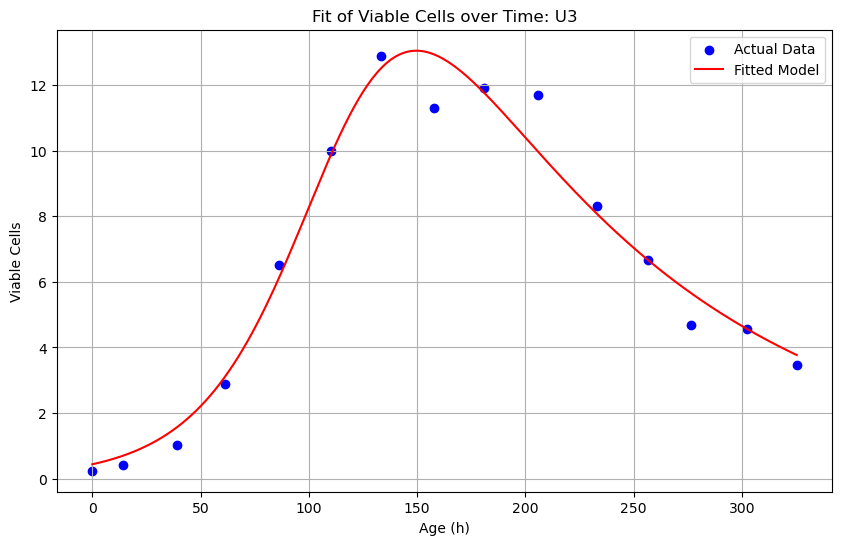

at 0==> initial_vcd:0.29494674251150815; final_vcd:0.43888499566104106; delta_time:12
0.03269102112971663 growth rate
0.03312021697429566 growth rate_log
at 14.033333333333337==> initial_vcd:0.4693808386652314; final_vcd:0.6967721945917276; delta_time:12
0.03249878724341648 growth rate
0.032920338219621925 growth rate_log
at 39.25==> initial_vcd:1.072192021686244; final_vcd:1.5760444810661667; delta_time:12
0.0317099359552574 growth rate
0.032101086979095 growth rate_log
at 61.116666666666674==> initial_vcd:2.148558305210341; final_vcd:3.0923691539919185; delta_time:12
0.03001411665297241 growth rate
0.030345037677878023 growth rate_log
at 86.13333333333334==> initial_vcd:4.481878449734425; final_vcd:6.108381597012518; delta_time:12
0.025597469437301706 growth rate
0.025801633749631053 growth rate_log
at 110.25==> initial_vcd:7.993145897490507; final_vcd:9.880665455019935; delta_time:12
0.017600420342211258 growth rate
0.017666287633620843 growth rate_log
at 133.13333333333333==> initi

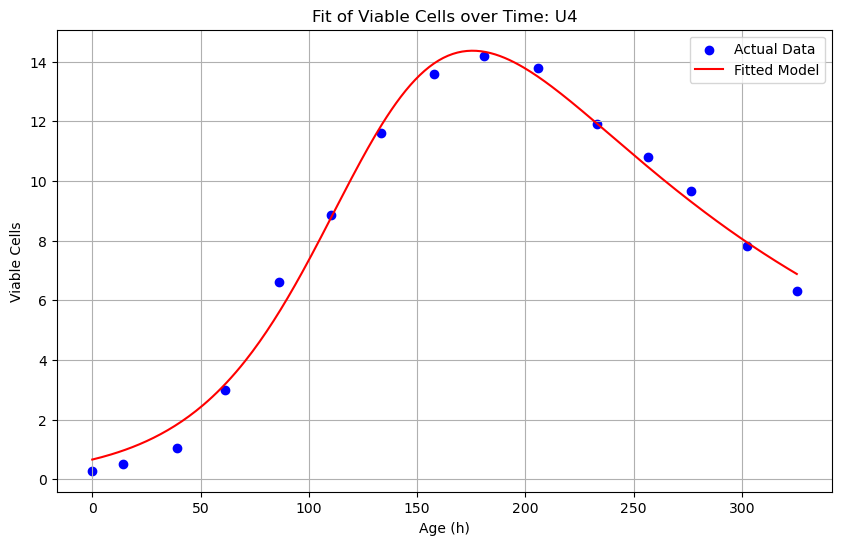

at 0==> initial_vcd:0.48140214823160127; final_vcd:0.6622327334822172; delta_time:12
0.026353193101226566 growth rate
0.02657617229160528 growth rate_log
at 14.016666666666666==> initial_vcd:0.6985738945747438; final_vcd:0.9587064727643254; delta_time:12
0.02616058848743566 growth rate
0.026378665682693998 growth rate_log
at 39.25==> initial_vcd:1.3543077244604989; final_vcd:1.843569201678712; delta_time:12
0.02549928637648236 growth rate
0.02570108807275076 growth rate_log
at 61.1==> initial_vcd:2.3630011725736617; final_vcd:3.1706986307310703; delta_time:12
0.02432662555092739 growth rate
0.024501621451950405 growth rate_log
at 86.11666666666667==> initial_vcd:4.299049826983411; final_vcd:5.588205495420204; delta_time:12
0.021730932505196605 growth rate
0.021855348943220537 growth rate_log
at 110.25==> initial_vcd:7.11361523993502; final_vcd:8.768039074016688; delta_time:12
0.01736200147852661 growth rate
0.017425216623219626 growth rate_log
at 133.11666666666667==> initial_vcd:10.28

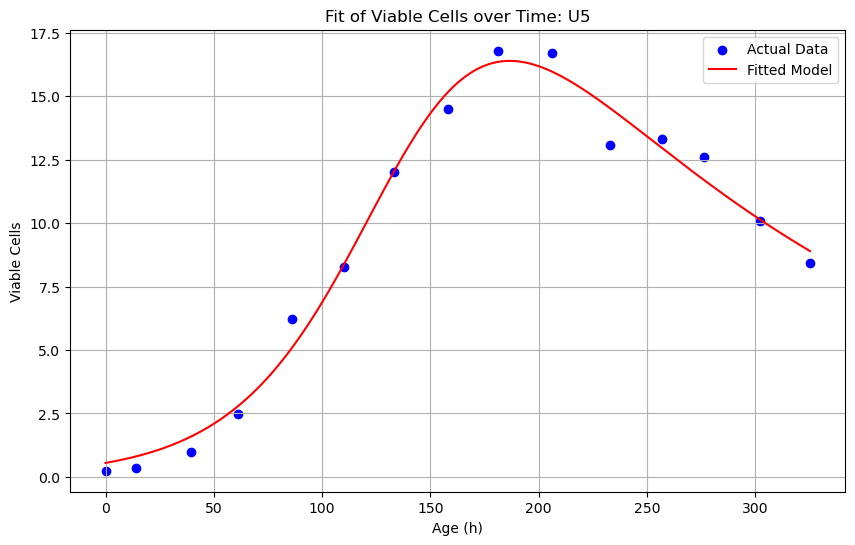

at 0==> initial_vcd:0.3954423714497342; final_vcd:0.5486936132584449; delta_time:12
0.027053172475657514 growth rate
0.027294594854740645 growth rate_log
at 14.000000000000004==> initial_vcd:0.5794031247043727; final_vcd:0.8024788554854466; delta_time:12
0.026904821827407617 growth rate
0.027142252335941905 growth rate_log
at 39.25==> initial_vcd:1.1465685896543067; final_vcd:1.5779799412327198; delta_time:12
0.026390387660419668 growth rate
0.026614322004096348 growth rate_log
at 61.1==> initial_vcd:2.0430055492232544; final_vcd:2.7798830293432513; delta_time:12
0.025464596859883535 growth rate
0.025665568249723648 growth rate_log
at 86.1==> initial_vcd:3.8359499811167774; final_vcd:5.086319785938154; delta_time:12
0.02335672120559706 growth rate
0.02351145192881582 growth rate_log
at 110.25==> initial_vcd:6.633194717711448; final_vcd:8.40245225828877; delta_time:12
0.01961181033536942 growth rate
0.0197030877281984 growth rate_log
at 133.1==> initial_vcd:10.127163314881596; final_vcd

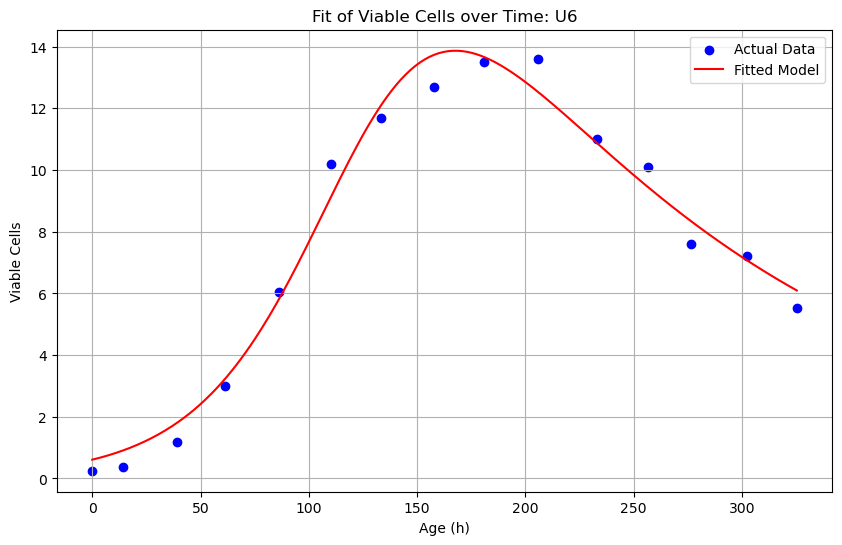

at 0==> initial_vcd:0.4345442005021505; final_vcd:0.6100575073866434; delta_time:12
0.028003226103471286 growth rate
0.028271296693240282 growth rate_log
at 13.98333333333333==> initial_vcd:0.6451238110317706; final_vcd:0.903349716668632; delta_time:12
0.02779359812717688 growth rate
0.028055625675995375 growth rate_log
at 39.25==> initial_vcd:1.3053696783452304; final_vcd:1.8110340533425917; delta_time:12
0.027043157141661327 growth rate
0.027284308604401907 growth rate_log
at 61.1==> initial_vcd:2.355815268990165; final_vcd:3.2133108043206535; delta_time:12
0.02566218122444454 growth rate
0.02586791290490247 growth rate_log
at 86.1==> initial_vcd:4.420075881406533; final_vcd:5.8015615407673105; delta_time:12
0.022525511362199727 growth rate
0.022664187400138924 growth rate_log
at 110.25==> initial_vcd:7.421946283381063; final_vcd:9.134007646617151; delta_time:12
0.017235102353258293 growth rate
0.017296935566308402 growth rate_log
at 133.08333333333334==> initial_vcd:10.6350749008322

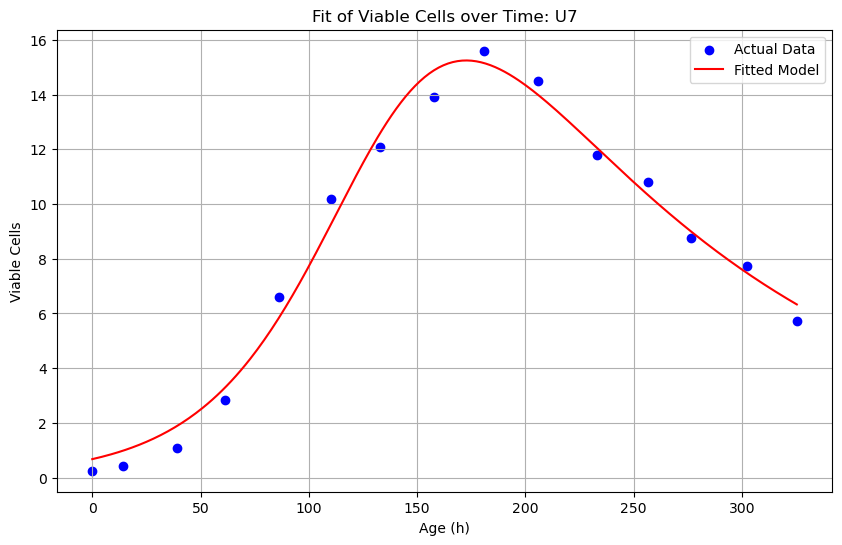

at 0==> initial_vcd:0.4919198277652409; final_vcd:0.6771625900375716; delta_time:12
0.02640856901267893 growth rate
0.026632971258110812 growth rate_log
at 13.966666666666665==> initial_vcd:0.7134757591069941; final_vcd:0.9801757119469338; delta_time:12
0.026245064524597572 growth rate
0.026465282648354665 growth rate_log
at 39.25==> initial_vcd:1.388709127624173; final_vcd:1.8942749521749824; delta_time:12
0.0256659699560965 growth rate
0.025871793653814524 growth rate_log
at 61.08333333333333==> initial_vcd:2.432326655106372; final_vcd:3.275028764547821; delta_time:12
0.02460865694291817 growth rate
0.024789865134186784 growth rate_log
at 86.08333333333333==> initial_vcd:4.460252433811427; final_vcd:5.82946660101938; delta_time:12
0.022177705769113626 growth rate
0.022310011677560044 growth rate_log
at 110.25==> initial_vcd:7.472135142708291; final_vcd:9.268295108133762; delta_time:12
0.01788245521482463 growth rate
0.017951555030772986 growth rate_log
at 133.06666666666666==> initia

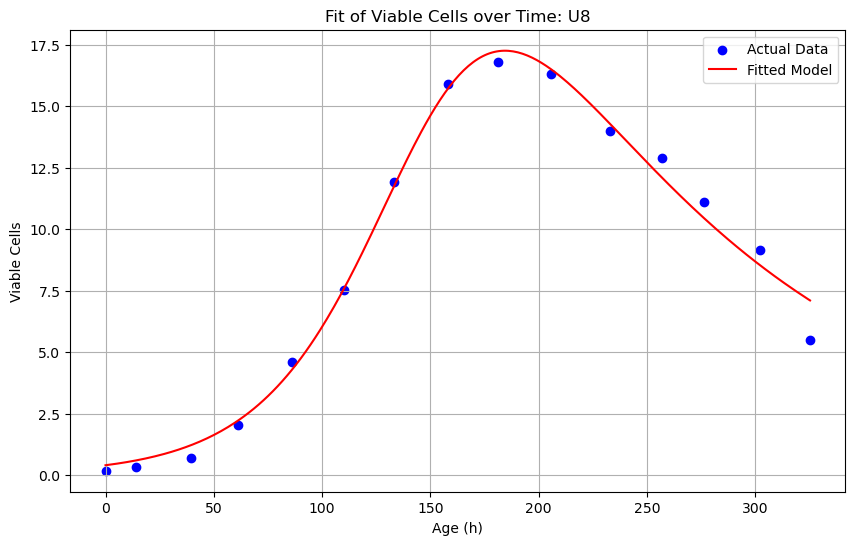

at 0==> initial_vcd:0.28133403850908456; final_vcd:0.39627689347117795; delta_time:12
0.028271595969824523 growth rate
0.02854754003113773 growth rate_log
at 13.950000000000001==> initial_vcd:0.41893462974701245; final_vcd:0.5895281969616714; delta_time:12
0.02819366311719928 growth rate
0.028467304833551366 growth rate_log
at 39.25==> initial_vcd:0.859511956073142; final_vcd:1.2051165069648246; delta_time:12
0.02789884936352729 growth rate
0.02816389935870985 growth rate_log
at 61.08333333333334==> initial_vcd:1.5858886997421073; final_vcd:2.2075861285269927; delta_time:12
0.02731433390796812 growth rate
0.027562893751028845 growth rate_log
at 86.08333333333334==> initial_vcd:3.1337104385570203; final_vcd:4.282247531720008; delta_time:12
0.02581228880041067 growth rate
0.026021687491739 growth rate_log
at 110.25==> initial_vcd:5.783741633325382; final_vcd:7.608109677428757; delta_time:12
0.022704951961326183 growth rate
0.022846993879167127 growth rate_log
at 133.05==> initial_vcd:9.4

In [4]:
# Define function: fitted_vcd model
def fitted_vcd(time_value, A, B, C, D):
    return A / (np.exp(B * time_value) + C * np.exp(-D * time_value))

# Dictionary of DataFrames grouped by Batch ID
batch_dfs = {batch_id: df_group for batch_id, df_group in df.groupby('Batch ID')}

# For each Batch ID, remove the first row, fit the model, and calculate the growth rate
for batch_id in ['U1', 'U2', 'U3', 'U4', 'U5', 'U6', 'U7', 'U8']:
    if batch_id in batch_dfs:  # Check if the Batch ID exists
        # Identify the index of the first row
        first_row_index = batch_dfs[batch_id].index[0]
        # Remove the first row
        batch_dfs[batch_id] = batch_dfs[batch_id].drop(first_row_index)
        
        # Extract valid data (excluding NaN)
        time_values = batch_dfs[batch_id]['Age (h)'].dropna().values  # Array of time values
        viable_cells = batch_dfs[batch_id]['Viable Cells'].dropna().values  # Array of cell counts

        # Fit model parameters using curve_fit
        params, _ = curve_fit(fitted_vcd, time_values, viable_cells, p0=[100, 0.01, 2, 0.05])

        # Set range of time values for predictions
        time_values_fit = np.linspace(min(time_values), max(time_values), 300)

        # Calculate predictions based on the fitted model
        fitted_values = fitted_vcd(time_values_fit, *params)

        # Plot actual data and fitted model
        plt.figure(figsize=(10, 6))
        plt.scatter(time_values, viable_cells, color='blue', label='Actual Data')  # Actual data
        plt.plot(time_values_fit, fitted_values, color='red', label='Fitted Model')  # Fitted model
        plt.xlabel('Age (h)')
        plt.ylabel('Viable Cells')
        plt.title(f'Fit of Viable Cells over Time: {batch_id}')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Calculate growth rate using delta_time
        delta_time = 12 # 0.5 for instant time point
        growth_rates = []
        growth_rates_log = []
###--------------------------fixed part-----------------------------
        for time in time_values:
            final_vcd = fitted_vcd(time, *params)
            initial_vcd = fitted_vcd(time - delta_time, *params)
            growth_rate = (final_vcd - initial_vcd) / ((final_vcd + initial_vcd) / 2 * delta_time)
            growth_rates.append(growth_rate)
            if initial_vcd > 0:  # Ensure no division by zero
                growth_rate_log = (np.log(final_vcd) - np.log(initial_vcd)) / delta_time
                growth_rates_log.append(growth_rate_log)
            else:
                growth_rates_log.append(np.nan)  # Handle case where initialvcd is zero or negative

            print(f"at {time}==> initial_vcd:{initial_vcd}; final_vcd:{final_vcd}; delta_time:{delta_time}\n{growth_rate} growth rate")
            print(f"{growth_rate_log} growth rate_log")
###-------------------------------------------------------------------
        # Add results to DataFrame
        batch_dfs[batch_id]['Growth Rate'] = growth_rates
        # Add results to DataFrame
        batch_dfs[batch_id]['Growth Rate_R'] = growth_rate_log


In [5]:
#file_path_meta = r"C:\Users\user\Documents\DC\Manual curation_iCHO\Whole-Cell-Network-Reconstruction-for-CHO-cells_origin\Whole-Cell-Network-Reconstruction-for-CHO-cells\Data\ZeLa Data"
file_name_meta = "processing_ELN_Excel data sheet_Bio141 to Bio148.xlsx"
sheet_name_meta = "Amount of uptake and secretion"
#full_path_meta = f"{file_path_meta}/{file_name_meta}"

df_meta = pd.read_excel(file_name_meta, sheet_name=sheet_name_meta, header = 2)
df_meta.columns = df_meta.columns.str.strip() # Remove trailing blank spaces from the column names

start_row = 0
end_row = 129


metabolite = df_meta.iloc[start_row:end_row]  
batch_dfs_meta = {batch_id: df_group for batch_id, df_group in metabolite.groupby('Batch ID')}

In [6]:
def calculate_specific_rate(delta_met, growth_rate, VC_t, VC_i, initial_time, current_time):
    try:
        time_interval = current_time - initial_time
        cell_delta = VC_t - VC_i

        # Zero division handling for `cell_delta`
        if cell_delta == 0:
            return 0

        # Zero division handling for other parameters
        if time_interval == 0 or growth_rate == 0:
            return float('nan')

        SR = delta_met / ((cell_delta / growth_rate) / time_interval)/(24/(200/1000))
        return SR
    except Exception as e:
        print(f"Error calculating specific rate: {e}")
        return float('nan')

In [7]:
intervals = [("P0", "P2"), ("P2", "P4"), ("P4", "P6"), ("P6", "P8"), ("P8", "P12"), ("P12", "P14")]
# Ensure results structures are initialized
results = []
results_for_check = []
cumulative_results = {}

# Loop through each Batch ID to calculate specific rates
for batch_id in ['U1', 'U2', 'U3', 'U4', 'U5', 'U6', 'U7', 'U8']:
    if batch_id in batch_dfs_meta:
        # Drop the first row
        first_row_index = batch_dfs_meta[batch_id].index[0]
        batch_dfs_meta[batch_id] = batch_dfs_meta[batch_id].drop(first_row_index)

        # Get the list of metabolites
        met_list = batch_dfs_meta[batch_id].columns[2:].tolist()

        # Calculate the specific rates for each interval
        for start, end in intervals:
            end_row = batch_dfs_meta[batch_id][batch_dfs_meta[batch_id]['Sample ID'] == end]
            start_row = batch_dfs_meta[batch_id][batch_dfs_meta[batch_id]['Sample ID'] == start]

            # Proceed only if both rows exist
            if not end_row.empty and not start_row.empty:
                try:
                    # Extract necessary values
                    growth_rate = batch_dfs[batch_id][batch_dfs[batch_id]['Sample ID'] == end]['Growth Rate'].values[0]
                    VC_t = batch_dfs[batch_id][batch_dfs[batch_id]['Sample ID'] == end]['Viable Cells'].values[0]
                    VC_i = batch_dfs[batch_id][batch_dfs[batch_id]['Sample ID'] == start]['Viable Cells'].values[0]
                    current_time = batch_dfs[batch_id][batch_dfs[batch_id]['Sample ID'] == end]['Age (h)'].values[0]
                    initial_time = batch_dfs[batch_id][batch_dfs[batch_id]['Sample ID'] == start]['Age (h)'].values[0]
                    # Initialize cumulative results structure if missing
                    if batch_id not in cumulative_results:
                        cumulative_results[batch_id] = {}
                    if (start, end) not in cumulative_results[batch_id]:
                        cumulative_results[batch_id][(start, end)] = {}

                    # Save the growth rate in the cumulative results
                    cumulative_results[batch_id][(start, end)]['SGR'] = growth_rate
                    # Loop through each metabolite to calculate specific rates
                    results.append({
                        'Batch ID': batch_id,
                        'Interval': f"{start} to {end}",
                        'metabolite': 'SGR',
                        'Specific Rate': growth_rate
                    })
                    for met_name in met_list:
                        delta_met = end_row[met_name].values[0]

                        # Calculate specific rate
                        specific_rate = calculate_specific_rate(delta_met, growth_rate, VC_t, VC_i, initial_time, current_time)

                        # Save the results
                        results.append({
                            'Batch ID': batch_id,
                            'Interval': f"{start} to {end}",
                            'metabolite': met_name,
                            'Specific Rate': specific_rate
                        })
                        results_for_check.append({
                            'check': f"{delta_met}/{growth_rate}/{VC_t}/{VC_i}/{initial_time}/{current_time}"
                        })

                        # Initialize cumulative results structure if missing
                        if batch_id not in cumulative_results:
                            cumulative_results[batch_id] = {}
                        if (start, end) not in cumulative_results[batch_id]:
                            cumulative_results[batch_id][(start, end)] = {}

                        # Store cumulative results
                        cumulative_results[batch_id][(start, end)][met_name] = specific_rate


                except Exception as e:
                    print(f"Error processing interval {start}-{end} for batch {batch_id}: {e}")


In [8]:
# Convert the example results to a Pandas DataFrame
results_df = pd.DataFrame(results)

# Create a pivot table: Use Batch ID and Interval as indices and metabolites as columns
pivot_df = results_df.pivot_table(index=['Batch ID', 'Interval'], columns='metabolite', values='Specific Rate')

# Export to an Excel file
pivot_df.to_excel('specific_rates_R.xlsx', sheet_name='Specific Rates')


In [9]:

# Assuming pivot_df is indexed by ('Batch ID', 'Interval') and the columns are various metabolites including 'SGR'
group1_batches = ['U1', 'U2', 'U3']
group2_batches = ['U4', 'U5', 'U6', 'U7', 'U8']

# Create masks for the groups
mask_group1 = pivot_df.index.get_level_values('Batch ID').isin(group1_batches)
mask_group2 = pivot_df.index.get_level_values('Batch ID').isin(group2_batches)

# Filter data for each group
data_group1 = pivot_df[mask_group1]
data_group2 = pivot_df[mask_group2]

# Calculate means for each group by Interval
# Here, we use groupby on the 'Interval' level of the index, then calculate mean
group1_averages = data_group1.groupby(level='Interval').mean()
group2_averages = data_group2.groupby(level='Interval').mean()


In [10]:
# Use ExcelWriter to add these DataFrames to an existing Excel file as new sheets
with pd.ExcelWriter('specific_rates_R.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    group1_averages.to_excel(writer, sheet_name='Avg_U1_U3')
    group2_averages.to_excel(writer, sheet_name='Avg_U4_U8')

### Generate Uptake and Secretion Rate Intervals
Here we calculate the mean and the std for each utake and secretion rate. We then generate intervals going from mean-std to mean+std for each metabolite. We then save the results in the 'specific_rates_R.xlsx' in new sheets called 'Int_U1_U3' and 'Int_U4_U8'

In [25]:
# Assuming pivot_df is indexed by ('Batch ID', 'Interval') and the columns are various metabolites including 'SGR'
group1_batches = ['U1', 'U2', 'U3']
group2_batches = ['U4', 'U5', 'U6', 'U7', 'U8']

# Create masks for the groups
mask_group1 = pivot_df.index.get_level_values('Batch ID').isin(group1_batches)
mask_group2 = pivot_df.index.get_level_values('Batch ID').isin(group2_batches)

# Filter data for each group
data_group1 = pivot_df[mask_group1]
data_group2 = pivot_df[mask_group2]

# Calculate means and standard deviations for each group by Interval
group1_stats = data_group1.groupby(level='Interval').agg(['mean', 'std'])
group2_stats = data_group2.groupby(level='Interval').agg(['mean', 'std'])


def create_interval_df(group_stats):
    mean_df = group_stats.xs('mean', axis=1, level=1)
    std_df = group_stats.xs('std', axis=1, level=1)
    lower_bound_df = mean_df - (3*std_df)
    upper_bound_df = mean_df + (3*std_df)
    
    interval_df = mean_df.copy()  # Create a DataFrame to hold the intervals with the same index
    for col in mean_df.columns:
        interval_df[f'{col}'] = list(zip(lower_bound_df[col], upper_bound_df[col]))
    return interval_df

# Create intervals DataFrame for each group
group1_intervals_df = create_interval_df(group1_stats)
group2_intervals_df = create_interval_df(group2_stats)

In [26]:
# Use ExcelWriter to add these DataFrames to an existing Excel file as new sheets
with pd.ExcelWriter('specific_rates_R.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    group1_intervals_df.to_excel(writer, sheet_name='Int_U1_U3')
    group2_intervals_df.to_excel(writer, sheet_name='Int_U4_U8')

In [27]:
# Create a mapping dict to incorporate all the uptake and secretion values to reactions in our reconstruction

mapping_dict = {
    "3-hydroxybutyric acid": "EX_bhb_e",
    "NH4": "EX_nh4_e",
    "acetic acid": "EX_ac_e",
    "alanine": "EX_ala_L_e",
    "arginine": "EX_arg_L_e",
    "asparagine": "EX_asn_L_e",
    "aspartic acid": "EX_asp_L_e",
    "butyric & 2-hydroxy- butyric acids": "EX_2hb_e",
    "citric acid": "EX_cit_e",
    "cystine": "EX_cys_L_e",
    "ethanol": "EX_etoh_e",
    "formic acid": "EX_for_e",
    "fumaric acid": "EX_fum_e",
    "glucose": "EX_glc_e",
    "glutamic acid": "EX_glu_L_e",
    "glutamine": "EX_gln_L_e",
    "glycine": "EX_gly_e",
    "histidine": "EX_his_L_e",
    "hydroxyproline": "EX_4hpro_e",
    "isoleucine": "EX_ile_L_e",
    "isovaleric acid": None,
    "lactic acid": "EX_lac_L_e",
    "leucine": "EX_leu_L_e",
    "lysine": "EX_lys_L_e",
    "malic acid": "EX_mal_L_e",
    "methionine": "EX_met_L_e",
    "phenylalanine": "EX_phe_L_e",
    "proline": "EX_pro_L_e",
    "pyroglutamic acid": "EX_5oxpro_e",
    "pyruvic acid": "EX_pyr_e",
    "serine": "EX_ser_L_e",
    "threonine": "EX_thr_L_e",
    "tryptophan": "EX_trp_L_e",
    "tyrosine": "EX_tyr_L_e",
    "valine": "EX_val_L_e",
    "SGR": "biomass_cho_s"
}

In [28]:
# Create a new dictionary with the name of the reactions as keys, times as subkeys and uptake and secretion rates as values

# WT
uptake_secretion_wt_dict = {}
for original_col, new_col in mapping_dict.items():
    if new_col is not None and original_col in group1_intervals_df.columns:
        uptake_secretion_wt_dict[new_col] = group1_intervals_df[original_col].to_dict()
# Save the dictionary to a file
with open('../Uptake_Secretion_Rates/uptake_secretion_wt_dict.pkl', 'wb') as file:
    pickle.dump(uptake_secretion_wt_dict, file)

# ZeLa
uptake_secretion_zela_dict = {}
for original_col, new_col in mapping_dict.items():
    if new_col is not None and original_col in group2_intervals_df.columns:
        uptake_secretion_zela_dict[new_col] = group2_intervals_df[original_col].to_dict()
with open('../Uptake_Secretion_Rates/uptake_secretion_zela_dict.pkl', 'wb') as file:
    pickle.dump(uptake_secretion_zela_dict, file)